In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
DATA_PATH = '/dlabdata1/turkish_wiki'

# Preprocessing edits for analysis

In [209]:
edits = pd.read_csv(f'{DATA_PATH}/processed_data/account_edits.csv', index_col = 0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [210]:
edits.head()

,event_type,event_timestamp,event_user_id,event_user_groups,event_user_revision_count,event_user_seconds_since_previous_revision,page_id,page_title,page_revision_count,revision_minor_edit,revision_text_bytes,revision_text_bytes_diff,revision_is_identity_revert
1,create,2002-12-05 22:54:39+00:00,1,NaN,1,NaN,5,Main_Page,1.0,False,24,24.0,False
14,create,2003-03-13 16:30:04+00:00,6,NaN,1,NaN,10,Cengiz_Han,1.0,False,8540,8540.0,False
51,create,2003-08-02 01:08:44+00:00,13,NaN,2,303.0,24,Linux,1.0,False,257,257.0,False
52,create,2003-08-02 01:10:08+00:00,13,NaN,3,84.0,24,Linux,2.0,False,259,2.0,False
53,create,2003-08-02 01:11:50+00:00,13,NaN,4,102.0,24,Linux,3.0,False,261,2.0,False


In [211]:
edits = edits[['event_user_id', 'event_timestamp', 'page_id','page_revision_count', 
               'revision_minor_edit', 'revision_text_bytes','revision_is_identity_revert']]

In [212]:
edits[['revision_minor_edit','revision_is_identity_revert']] = edits[['revision_minor_edit','revision_is_identity_revert']].convert_dtypes()

In [213]:
edits['event_timestamp'] = pd.to_datetime(edits['event_timestamp'],   utc = True)

In [214]:
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15 19:00', utc = True)]

# Characterize blocked users
## 1) Change binning

In [215]:
edits.columns

Index(['event_user_id', 'event_timestamp', 'page_id', 'page_revision_count',
       'revision_minor_edit', 'revision_text_bytes',
       'revision_is_identity_revert'],
      dtype='object')

In [216]:
blocked_days = (block_dates[1] - block_dates[0]).days

In [217]:
preblock_edit_counts = edits[(edits['event_timestamp'] >= block_dates[0] - pd.Timedelta(days=blocked_days)) & (edits['event_timestamp'] < block_dates[0])].groupby('event_user_id').agg(
        {'event_timestamp': ['min', 'max'],'revision_minor_edit': 'size'}).reset_index()

In [218]:
block_edit_counts = edits[(edits['event_timestamp'] >= block_dates[0]) & (edits['event_timestamp'] < block_dates[1])].groupby('event_user_id').agg(
        {'event_timestamp': ['min', 'max'],'revision_minor_edit': 'size'}).reset_index()

In [219]:
preblock_edit_counts.columns = ['user_id','first_edit_before_block', 'last_edit_before_block', 'number_of_edits']
block_edit_counts.columns = ['user_id', 'first_edit_during_block', 'last_edit_during_block', 'number_of_edits']

In [220]:
preblock_edit_counts.sort_values('number_of_edits', ascending = False)

,user_id,first_edit_before_block,last_edit_before_block,number_of_edits
10332,573665,2014-08-12 21:22:49+00:00,2017-04-28 21:16:47+00:00,222814
1105,90501,2014-08-14 19:22:44+00:00,2017-04-28 22:04:57+00:00,216000
2800,221544,2014-08-12 13:00:53+00:00,2017-04-28 19:06:33+00:00,73737
1061,86010,2014-08-12 02:06:07+00:00,2017-04-28 21:23:09+00:00,47235
1471,123656,2014-08-12 08:53:00+00:00,2017-04-28 20:42:54+00:00,35633
...,...,...,...,...
46323,842788,2016-03-06 16:35:28+00:00,2016-03-06 16:35:28+00:00,1
46322,842779,2016-02-14 18:12:52+00:00,2016-02-14 18:12:52+00:00,1
46321,842773,2016-02-14 18:05:50+00:00,2016-02-14 18:05:50+00:00,1
21400,675719,2015-01-21 19:13:52+00:00,2015-01-21 19:13:52+00:00,1


## Editor activity levels

In [221]:
preblock_edit_counts['edits_per_day'] = preblock_edit_counts['number_of_edits']/(blocked_days)

In [222]:
preblock_edit_counts

,user_id,first_edit_before_block,last_edit_before_block,number_of_edits,edits_per_day
0,25,2014-11-17 07:39:39+00:00,2016-09-15 08:51:50+00:00,2,0.002018
1,39,2015-07-08 11:00:43+00:00,2017-03-16 10:51:19+00:00,14,0.014127
2,47,2016-07-01 08:19:57+00:00,2016-07-01 08:53:14+00:00,7,0.007064
3,89,2016-09-14 13:27:45+00:00,2016-09-14 13:27:45+00:00,1,0.001009
4,137,2014-12-03 09:29:04+00:00,2016-08-24 09:13:13+00:00,10,0.010091
...,...,...,...,...,...
68822,964220,2017-04-28 21:44:27+00:00,2017-04-28 21:44:27+00:00,1,0.001009
68823,964228,2017-04-28 22:33:28+00:00,2017-04-28 22:33:28+00:00,1,0.001009
68824,964229,2017-04-28 22:23:20+00:00,2017-04-28 22:23:20+00:00,1,0.001009
68825,964230,2017-04-28 22:46:12+00:00,2017-04-28 22:52:38+00:00,3,0.003027


In [223]:
preblock_edit_counts = preblock_edit_counts[preblock_edit_counts['number_of_edits'] > 1]

In [224]:
summary_stats = preblock_edit_counts.edits_per_day.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

In [225]:
summary_stats

count    39467.000000
mean         0.052612
std          1.737151
min          0.002018
25%          0.002018
50%          0.003027
75%          0.007064
99%          0.341070
max        224.837538
Name: edits_per_day, dtype: float64

In [226]:
bins = [0] +list(summary_stats.values[4:9])

In [227]:
preblock_edit_counts['preblock_daily_edit_category'] = pd.cut(preblock_edit_counts.edits_per_day, bins, right=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [228]:
preblock_edit_counts.preblock_daily_edit_category.unique()

[(0.0, 0.00202], (0.00706, 0.341], (0.00303, 0.00706], (0.00202, 0.00303], (0.341, 224.838]]
Categories (5, interval[float64]): [(0.0, 0.00202] < (0.00202, 0.00303] < (0.00303, 0.00706] < (0.00706, 0.341] < (0.341, 224.838]]

## Analysing drop by user activity

In [229]:
daily_active_users = edits.set_index('event_timestamp').groupby([pd.Grouper(freq= 'D'), 'preblock']).event_user_id.nunique()

In [230]:
daily_active_users = daily_active_users.reset_index()

In [231]:
daily_active_users = daily_active_users[daily_active_users['event_timestamp'] >= block_dates[0]-pd.Timedelta(days=blocked_days)]

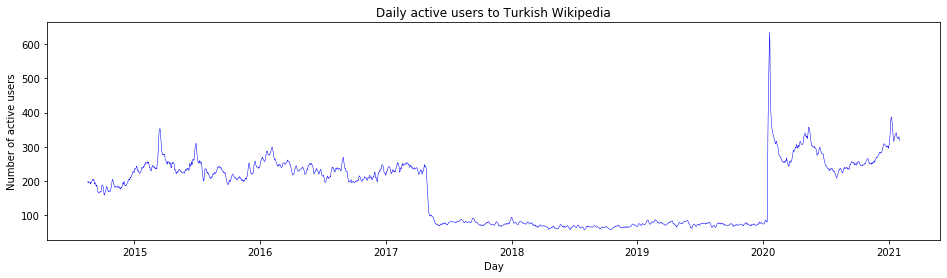

In [232]:
plt.figure(figsize=(16,4))
plt.title("Daily active users to Turkish Wikipedia")
rolling_mean = daily_active_users.rolling(window=7).mean()
plt.plot(daily_active_users.event_timestamp.values, rolling_mean, color='blue', lw=0.5)
plt.ylabel("Number of active users")
plt.xlabel("Day")
# for date in block_dates:
#     plt.axvline(date)
plt.show()

In [233]:
daily_active_users['period'] = daily_active_users.apply(lambda row: 'pre-block' if row['event_timestamp'] < block_dates[0] else 'block' if not row['event_timestamp'] >= block_dates[1] else 'after-block', axis=1)

In [234]:
daily_active_users.groupby('period').describe()

event_user_id                                                      \
                    count        mean        std    min    25%    50%     75%   
period                                                                          
after-block         383.0  283.352480  71.960530  188.0  246.5  271.0  308.00   
block               992.0   73.993952  19.797970   40.0   67.0   73.0   79.25   
pre-block           991.0  228.420787  33.085221  137.0  207.0  228.0  248.00   

                     
                max  
period               
after-block  1285.0  
block         607.0  
pre-block     395.0

In [235]:
print(f"Median activity change for all users: {100*(73.0-228.0)/(228.0)}%")

Median activity change for all users: -67.98245614035088%


Wikipedia lost nearly 70% of their daily active users due to the block.

In [236]:
from matplotlib import cm

In [237]:
n = 5 # Number of colors
new_colors = [plt.get_cmap('magma')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(plt.cycler('color', new_colors[::-1])))

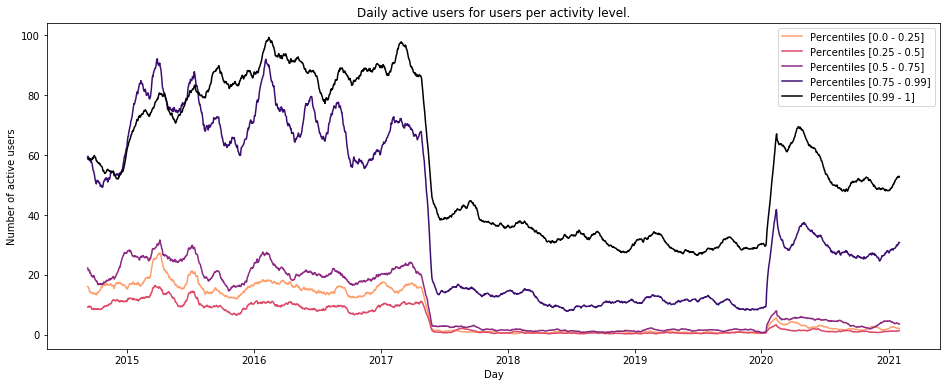

In [238]:
pctiles = ["[0.0 - 0.25]", "[0.25 - 0.5]", "[0.5 - 0.75]", "[0.75 - 0.99]", "[0.99 - 1]"]
plt.figure(figsize=(16,6))
plt.title(f"Daily active users for users per activity level.")
for idx, category in enumerate(sorted(preblock_edit_counts.preblock_daily_edit_category.unique())):
    category_users = preblock_edit_counts[preblock_edit_counts['preblock_daily_edit_category'] == category].user_id
    df = edits[(edits['event_timestamp'] >= block_dates[0]-pd.Timedelta(days=blocked_days))&(edits.event_user_id.isin(category_users))].set_index('event_timestamp').groupby(pd.Grouper(freq= 'D')).event_user_id.nunique().reset_index()
    rolling_mean = df.rolling(window=30).mean()
    plt.plot(df.event_timestamp.values, rolling_mean, label = f"Percentiles {pctiles[idx]}")

plt.ylabel("Number of active users")
plt.xlabel("Day")
plt.legend()
plt.show()

In [240]:
edits_cat_slice = pd.merge(edits[['event_user_id']], preblock_edit_counts[['user_id', 'preblock_daily_edit_category']], how = 'left', left_on ='event_user_id', right_on='user_id' )

In [248]:
edits = edits.reset_index()

In [249]:
edits['preblock_daily_edit_category'] = edits_cat_slice['preblock_daily_edit_category']

In [250]:
edits = edits[~edits.preblock_daily_edit_category.isna()]

,index,event_user_id,event_timestamp,page_id,page_revision_count,revision_minor_edit,revision_text_bytes,revision_is_identity_revert,preblock_daily_edit_category
20,176,25,2003-10-25 18:18:57+00:00,2740662,60.0,True,6363,False,"(0.0, 0.00202]"
21,186,25,2003-10-31 03:18:13+00:00,2740662,61.0,True,6388,False,"(0.0, 0.00202]"
30,243,25,2003-11-26 16:34:37+00:00,2740662,81.0,True,4335,False,"(0.0, 0.00202]"
38,545,25,2003-12-20 01:20:09+00:00,59,6.0,True,631,True,"(0.0, 0.00202]"
41,577,47,2003-12-24 15:23:38+00:00,649,2.0,False,627,False,"(0.00303, 0.00706]"
...,...,...,...,...,...,...,...,...,...
9538265,24670408,166490,2021-02-01 15:53:21+00:00,2908790,2.0,True,33,False,"(0.341, 224.838]"
9538268,24670415,775403,2021-02-01 15:54:48+00:00,2717907,160.0,False,22005,False,"(0.00706, 0.341]"
9538270,24670418,466504,2021-02-01 15:55:14+00:00,2908622,3.0,False,658,False,"(0.341, 224.838]"
9538271,24670419,466504,2021-02-01 15:56:02+00:00,2861149,10.0,False,7831,False,"(0.341, 224.838]"


In [251]:
edits = edits[(edits['event_timestamp'] >= block_dates[0] - pd.Timedelta(days=blocked_days))]

In [252]:
edits.loc[edits['event_timestamp'] < block_dates[0], 'period'] = 'pre-block'
edits.loc[(edits['event_timestamp'] >= block_dates[0]) & (edits['event_timestamp'] < block_dates[1]), 'period'] = 'block'
edits.loc[edits['event_timestamp'] >= block_dates[1], 'period'] = 'after-block'

In [258]:
edits

,index,event_user_id,event_timestamp,page_id,page_revision_count,revision_minor_edit,revision_text_bytes,revision_is_identity_revert,preblock_daily_edit_category,period
4440716,14523274,344317,2014-08-12 00:04:48+00:00,1758272,1.0,False,558,False,"(0.00303, 0.00706]",pre-block
4440717,14523275,369043,2014-08-12 00:05:00+00:00,1798433,2046.0,True,115877,True,"(0.341, 224.838]",pre-block
4440718,14523279,344317,2014-08-12 00:09:36+00:00,1758273,1.0,False,1275,False,"(0.00303, 0.00706]",pre-block
4440719,14523281,362126,2014-08-12 00:23:20+00:00,1758270,2.0,False,5155,False,"(0.341, 224.838]",pre-block
4440720,14523284,362126,2014-08-12 00:25:34+00:00,1758270,3.0,False,5196,False,"(0.341, 224.838]",pre-block
...,...,...,...,...,...,...,...,...,...,...
9538269,24670417,1175541,2021-02-01 15:55:06+00:00,3075,343.0,False,16149,False,NaN,after-block
9538270,24670418,466504,2021-02-01 15:55:14+00:00,2908622,3.0,False,658,False,"(0.341, 224.838]",after-block
9538271,24670419,466504,2021-02-01 15:56:02+00:00,2861149,10.0,False,7831,False,"(0.341, 224.838]",after-block
9538272,24670420,1221913,2021-02-01 15:56:08+00:00,747973,43.0,True,1655,False,NaN,after-block


## Analysing drop by user activity

In [264]:
daily_active_users = edits.set_index('event_timestamp').groupby([pd.Grouper(freq= 'D')]).event_user_id.nunique()

In [265]:
daily_active_users = daily_active_users.reset_index()

In [266]:
daily_active_users = daily_active_users[daily_active_users['event_timestamp'] >= block_dates[0]-pd.Timedelta(days=blocked_days)]

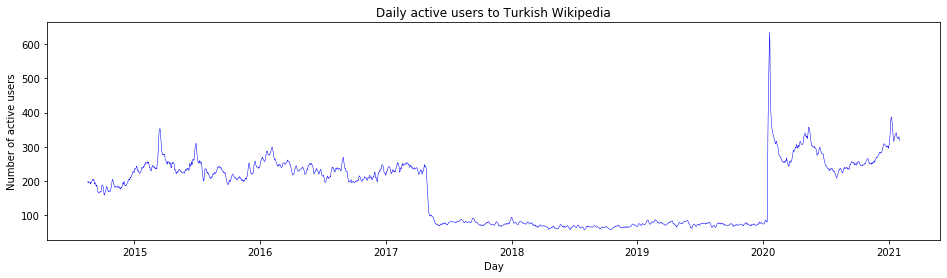

In [267]:
plt.figure(figsize=(16,4))
plt.title("Daily active users to Turkish Wikipedia")
rolling_mean = daily_active_users.rolling(window=7).mean()
plt.plot(daily_active_users.event_timestamp.values, rolling_mean, color='blue', lw=0.5)
plt.ylabel("Number of active users")
plt.xlabel("Day")
# for date in block_dates:
#     plt.axvline(date)
plt.show()

In [268]:
daily_active_users['period'] = daily_active_users.apply(lambda row: 'pre-block' if row['event_timestamp'] < block_dates[0] else 'block' if not row['event_timestamp'] >= block_dates[1] else 'after-block', axis=1)

In [269]:
daily_active_users.groupby('period').describe()

event_user_id                                                      \
                    count        mean        std    min    25%    50%     75%   
period                                                                          
after-block         383.0  283.352480  71.960530  188.0  246.5  271.0  308.00   
block               992.0   73.993952  19.797970   40.0   67.0   73.0   79.25   
pre-block           991.0  228.420787  33.085221  137.0  207.0  228.0  248.00   

                     
                max  
period               
after-block  1285.0  
block         607.0  
pre-block     395.0

In [270]:
print(f"Median activity change for all users: {100*(73.0-228.0)/(228.0)}%")

Median activity change for all users: -67.98245614035088%


Wikipedia lost nearly 70% of their daily active users due to the block.

## Analysing drop by user activity category


In [271]:
daily_active_users = edits.set_index('event_timestamp').groupby([pd.Grouper(freq= 'D'), 'preblock_daily_edit_category']).event_user_id.nunique()

In [273]:
daily_active_users = daily_active_users.reset_index()

In [275]:
daily_active_users['period'] = daily_active_users.apply(lambda row: 'pre-block' if row['event_timestamp'] < block_dates[0] else 'block' if not row['event_timestamp'] >= block_dates[1] else 'after-block', axis=1)

In [287]:
daily_active_users[daily_active_users['period'] == 'block']

,event_timestamp,preblock_daily_edit_category,event_user_id,period
4955,2017-04-29 00:00:00+00:00,"(0.0, 0.00202]",2,block
4956,2017-04-29 00:00:00+00:00,"(0.00202, 0.00303]",6,block
4957,2017-04-29 00:00:00+00:00,"(0.00303, 0.00706]",6,block
4958,2017-04-29 00:00:00+00:00,"(0.00706, 0.341]",33,block
4959,2017-04-29 00:00:00+00:00,"(0.341, 224.838]",54,block
...,...,...,...,...
9910,2020-01-15 00:00:00+00:00,"(0.0, 0.00202]",11,block
9911,2020-01-15 00:00:00+00:00,"(0.00202, 0.00303]",5,block
9912,2020-01-15 00:00:00+00:00,"(0.00303, 0.00706]",8,block
9913,2020-01-15 00:00:00+00:00,"(0.00706, 0.341]",51,block


In [290]:
daily_active_users = daily_active_users.pivot(index='event_timestamp', columns='preblock_daily_edit_category', values='event_user_id')

In [328]:
preblock = daily_active_users.loc[:block_dates[0] - pd.Timedelta(days=1)].to_numpy()

In [329]:
block = daily_active_users.loc[block_dates[0]:block_dates[1]- pd.Timedelta(days=1)].to_numpy()

In [339]:
afterblock = daily_active_users.loc[block_dates[1]:].to_numpy()

In [399]:
from sklearn.utils import resample
import matplotlib.ticker as mtick

In [381]:
def calculate_bootstrapped_pct_change(n_bootstrap = 1000, n_samples = 100):
    
    preblock_block_change = np.zeros((n_bootstrap, 5))
    block_afterblock_change = np.zeros((n_bootstrap, 5))
    preblock_afterblock_change = np.zeros((n_bootstrap, 5))

    for i in range(n_bootstrap):
    
        preblock_bootstrap = resample(preblock, n_samples = n_samples, replace=True)
        block_bootstrap = resample(block, n_samples = n_samples, replace=True)
        afterblock_bootstrap = resample(afterblock, n_samples = n_samples, replace=True)
        preblock_mean = preblock_bootstrap.mean(axis = 0)
        block_mean = block_bootstrap.mean(axis = 0)
        afterblock_mean = afterblock_bootstrap.mean(axis = 0)

        preblock_block_change[i, :] = 100*(block_mean-preblock_mean)/preblock_mean
        block_afterblock_change[i, :]= 100*(afterblock_mean-block_mean)/block_mean
        preblock_afterblock_change[i, :]= 100*(afterblock_mean-preblock_mean)/preblock_mean
        
    return preblock_block_change, block_afterblock_change, preblock_afterblock_change
    
    

In [382]:
preblock_block_change, block_afterblock_change, preblock_afterblock_change = calculate_bootstrapped_pct_change()

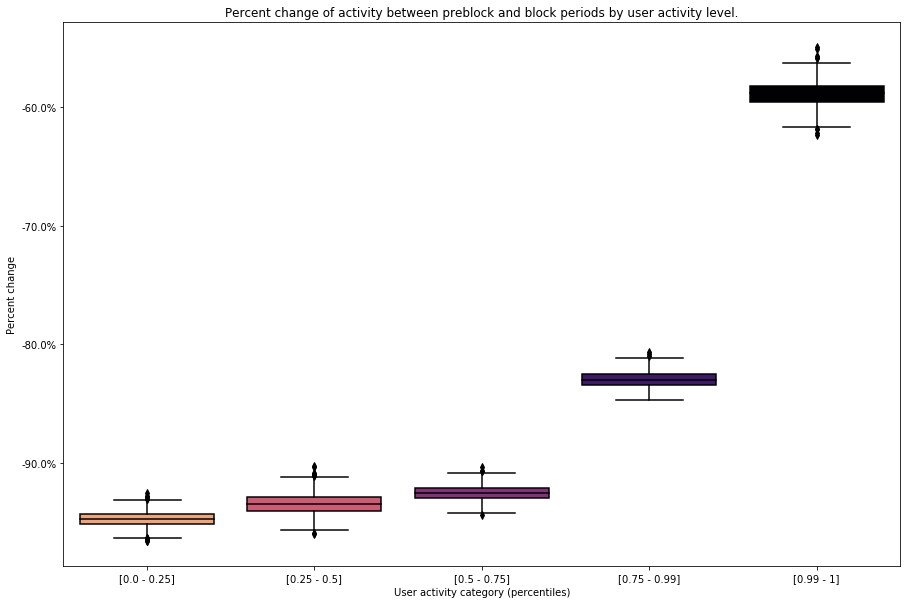

In [404]:
fig, ax = plt.subplots()
plt.title(f"Percent change of activity between preblock and block periods by user activity level.")
fig.set_size_inches(15, 10)
plt.xlabel('User activity category (percentiles)')
plt.ylabel('Percent change')

ax = sns.boxplot(data=preblock_block_change)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(list(range(5)), pctiles)

plt.show()

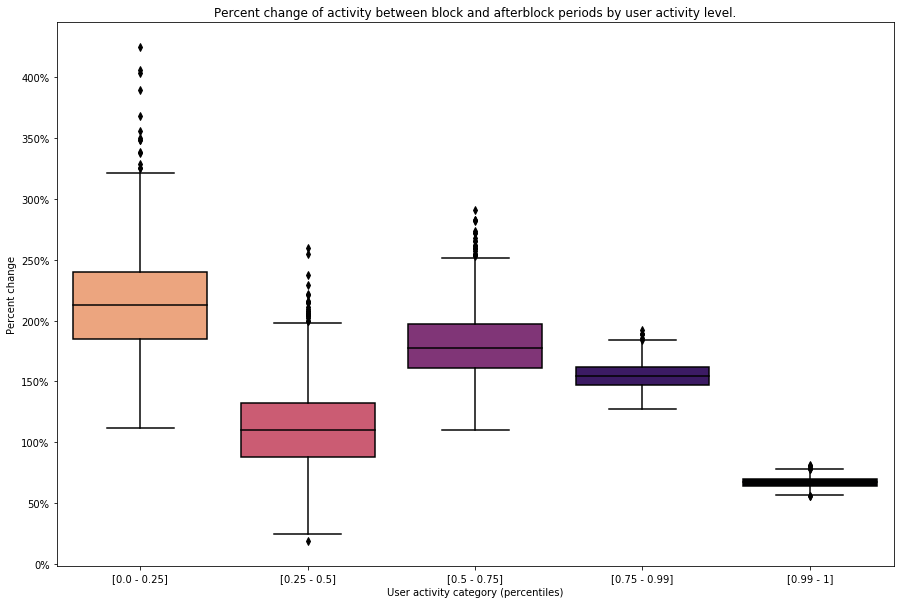

In [405]:
fig, ax = plt.subplots()
plt.title(f"Percent change of activity between block and afterblock periods by user activity level.")
fig.set_size_inches(15, 10)
plt.xlabel('User activity category (percentiles)')
plt.ylabel('Percent change')

ax = sns.boxplot(data=block_afterblock_change)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(list(range(5)), pctiles)

plt.show()

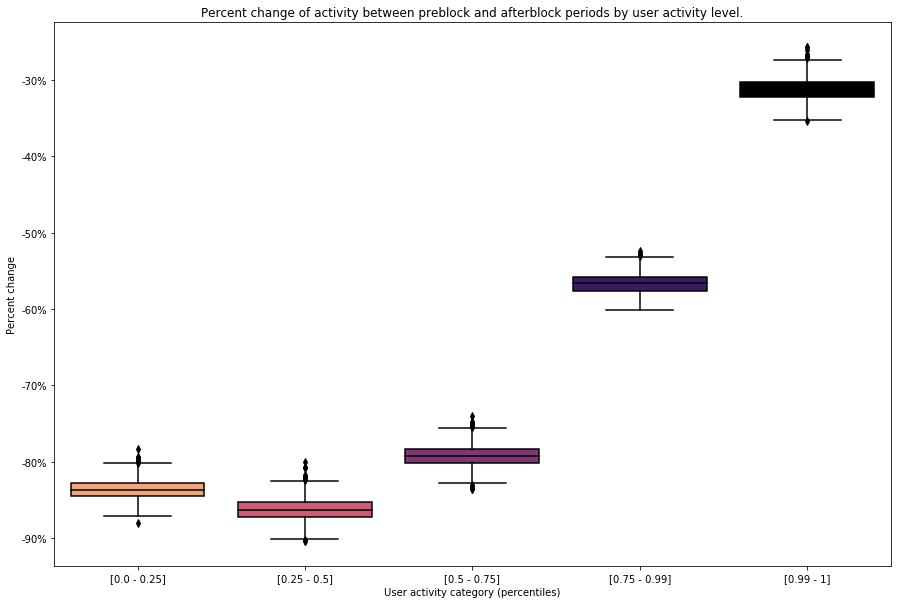

In [406]:
fig, ax = plt.subplots()
plt.title(f"Percent change of activity between preblock and afterblock periods by user activity level.")
fig.set_size_inches(15, 10)
plt.xlabel('User activity category (percentiles)')
plt.ylabel('Percent change')

ax = sns.boxplot(data=preblock_afterblock_change)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(list(range(5)), pctiles)

plt.show()